# Fake News Detection
### Introduction to AI Final Project
### Audrey Zhang, Priyanka Raja, Matt Oldfield

This project seeks to leverage natural language processing and machine learning to create an algorithm that can identify fake news. The dataset includes around 6000 observations of both fake and real news. The most common news topic is politics.

Methods used including: 

- tokenization
- lemmatization
- stopword removal
- sentiment analysis 
- topic modeling using LDA
- word embeddings using word2vec (pre-trained Google News)
- TFIDF word vectorization


Models used include: 

- Logistic regression
- Naive Bayes
- Decision Trees
- Random Forest
- XGBoost
- Multi-layer Perceptron (MLP) Classifier
- Long-short-term-memory (LSTM) neural nets
- Support Vector Machines
- BERT/RoBERTa

Outcomes evaluated using:
- confusion matrix
- F-1 scores
- AUC-ROC curves

In [50]:
#! /bin/env/python3
!pip install contractions
!pip install sklearn-pandas
!pip install wordcloud
import html
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords 
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem import WordNetLemmatizer 
from contractions import contractions_dict
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\audre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\audre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\audre\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\audre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
news_df=pd.read_csv('news.csv')
news_df.info()
news_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
news_df.drop(columns=['Unnamed: 0'], inplace=True)

#### Data pre-processing

In this section, the data are pre-processed and cleaned for analysis.

In [4]:
# Check for missing values
def check_for_missing(df):
    """
    Checks if a dataframe has any missing values (NaN or null).
    Also prints out some information about what columns contain the missing values.
    
    Args:
        df (dataframe): The dataframe to examine for missing values.
    
    Returns:
        A boolean representing whether (true) or not (false) the dataframe contains missing values.
    
    Raises:
        None
    """
    # This checks for any 'na' values in the dataset.
    has_missing = df.isna().any().any()
    if has_missing:
        print("The dataset has missing values. The following columns contain missing values:")
        for column in list(df.columns[df.isnull().any()]):
            num_missing = df[column].isna().sum().sum()
            print(f"\t{column}: {num_missing} missing values")
    else:
        print("The dataset does not have missing values.")

    return has_missing

def replace_missing(df, new_value):
    """
    Accepts:
        new_value (scalar): An int, string, etc. to replace null values with.

    Returns:
        Copy of dataframe with null values replaced with new_value.

    Raises:
        None
    """
    print("Performing data imputation.")
    df = df.fillna(new_value)
    return df
    
if check_for_missing(news_df) == True:
    news_df = replace_missing(news_df)

The dataset does not have missing values.


In [5]:
#sentiment analysis

analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score=analyser.polarity_scores(sentence)
    #score format {'neg': 0.0, 'neu': 0.326, 'pos': 0.674, 'compound': 0.7351}
    return(pd.Series(score)['compound'])


In [6]:
news_df['title_sent']=news_df['title'].apply(lambda x: sentiment_analyzer_scores(x))
news_df['text_sent']=news_df['text'].apply(lambda x: sentiment_analyzer_scores(x))

In [7]:
news_df['prediction_label']=0

In [8]:
news_df.loc[news_df['label']=='FAKE', 'prediction_label']=1

In [9]:
news_df['title_orig']=news_df['title']
news_df['text_orig']=news_df['text']

In [10]:
txt_cols=['title', 'text']
for t in txt_cols:
    news_df[t]=news_df[t].apply(lambda x: x.lower())

In [11]:
# tokenize words and remove punctuations 

for t in txt_cols:
    news_df[t]=news_df[t].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])

In [12]:
# remove stopwords & lemmatization

stopwords_list = list(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer() 

In [13]:
for t in txt_cols:
    
    news_df[t]=news_df[t].apply(lambda x: [
        lemmatizer.lemmatize(i) for i in x if i not in stopwords_list])

In [14]:
# expand contractions, if any

def expand_contractions(text):
    for i in text:
        if i in contractions_dict.keys():
            i=re.sub(i, contractions_dict[i], i)
    return text

for t in txt_cols:
    news_df[t]=news_df[t].apply(lambda x: expand_contractions(x))

In [15]:
news_df.head()

,title,text,label,title_sent,text_sent,prediction_label,title_orig,text_orig
0,"[smell, hillary, fear]","[daniel, greenfield, shillman, journalism, fel...",FAKE,-0.4939,-0.9988,1,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello..."
1,"[watch, exact, moment, paul, ryan, committed, ...","[google, pinterest, digg, linkedin, reddit, st...",FAKE,-0.5267,0.7723,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,"[kerry, go, paris, gesture, sympathy]","[secretary, state, john, kerry, said, monday, ...",REAL,0.3612,0.9595,0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...
3,"[bernie, supporter, twitter, erupt, anger, dnc...","[kaydee, king, kaydeeking, november, lesson, t...",FAKE,-0.3595,-0.4242,1,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,"[battle, new, york, primary, matter]","[primary, day, new, york, hillary, clinton, do...",REAL,-0.3612,0.9826,0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...


Conduct TFIDF and Word-2-Vec processing

In [82]:
# get pretiction labels 
categories=news_df['prediction_label']

In [83]:
# use DataFrameMapper to add tfidf to dataframe with other features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder

'''
mapper=DataFrameMapper([
    ('Headlines', TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False, ngram_range=(1,2), max_features=10000)),
    ('Summary', TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False,ngram_range=(1,2), max_features=10000)),
    ('headline_sent', None), 
    ('summary_sent', None),
    (['type'], OneHotEncoder()),
]) 
''' 

mapper=DataFrameMapper([
    ('title_orig', TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False, ngram_range=(1,2), max_features=10000)),
    ('text_orig', TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False,ngram_range=(1,2), max_features=10000)),
    ('title_sent', None), 
    ('text_sent', None),
]) 


tfidf_features=mapper.fit_transform(news_df)

In [84]:
tfidf_features

array([[ 0.20597028,  0.        ,  0.        , ...,  0.        ,
        -0.4939    , -0.9988    ],
       [ 0.31944858,  0.        ,  0.        , ...,  0.        ,
        -0.5267    ,  0.7723    ],
       [ 0.31573094,  0.        ,  0.        , ...,  0.        ,
         0.3612    ,  0.9595    ],
       ...,
       [ 0.29600604,  0.64033585,  0.        , ...,  0.        ,
        -0.2263    , -0.9991    ],
       [ 0.29472798,  0.        ,  0.        , ...,  0.        ,
         0.8271    ,  0.9966    ],
       [ 0.28451018,  0.        ,  0.        , ...,  0.        ,
        -0.4404    ,  0.9774    ]])

In [85]:
# we will also use w2v as an alternate vectorization method 
# Loading the pretrained word2vec model from Google (https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit).
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print(w2v_model.vector_size)

300


In [87]:
# for Word2Vec model, combine title and text columns 

news_df['combined']=news_df['title']+news_df['text']

In [88]:
# check that this worked
news_df.head()

,title,text,label,title_sent,text_sent,prediction_label,title_orig,text_orig,combined
0,"[smell, hillary, fear]","[daniel, greenfield, shillman, journalism, fel...",FAKE,-0.4939,-0.9988,1,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...","[smell, hillary, fear, daniel, greenfield, shi..."
1,"[watch, exact, moment, paul, ryan, committed, ...","[google, pinterest, digg, linkedin, reddit, st...",FAKE,-0.5267,0.7723,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,"[watch, exact, moment, paul, ryan, committed, ..."
2,"[kerry, go, paris, gesture, sympathy]","[secretary, state, john, kerry, said, monday, ...",REAL,0.3612,0.9595,0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,"[kerry, go, paris, gesture, sympathy, secretar..."
3,"[bernie, supporter, twitter, erupt, anger, dnc...","[kaydee, king, kaydeeking, november, lesson, t...",FAKE,-0.3595,-0.4242,1,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...","[bernie, supporter, twitter, erupt, anger, dnc..."
4,"[battle, new, york, primary, matter]","[primary, day, new, york, hillary, clinton, do...",REAL,-0.3612,0.9826,0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,"[battle, new, york, primary, matter, primary, ..."


In [89]:
# Word2Vec feature engineering
def word2vectorizer(row):
    vectors = np.array([w2v_model[token] for token in row if token in w2v_model.vocab])
    # If no words in a row are in the model's vocab, just return vector of zeros.
    # Otherwise get the average of each vector.
    if vectors.size == 0:
        vectors = np.zeros(w2v_model.vector_size)
    else:
        vectors = np.mean(vectors, axis=0)
    return vectors


w2v_vectors=news_df['combined'].apply(lambda x: word2vectorizer(x))
#text_vectors=news_df['text'].apply(lambda x: word2vectorizer(x))

print(w2v_vectors.shape)

(6335,)


Final datasets for modelling are:

tfidf_features: array of features including tfidf transformations for headline and summary text, headline and summary sentiments, and one-hot encoded features for news source type.

w2v_vectors: pandas Series of vectors, using w2v for title + body text combined.

categories: outcome labels for classification

### Topic modeling using LDA ( Latent Dirichlet Allocation)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
#
count_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(news_df['title'])
# Tweak the two parameters below 
number_topics = 10

In [24]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

LatentDirichletAllocation()

In [25]:
number_words = 4

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
        
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
clinton trump sander hillary

Topic #1:
obama trump vote source

Topic #2:
new clinton trump house

Topic #3:
trump gop cruz debate

Topic #4:
trump u putin election

Topic #5:
new dead trump death

Topic #6:
hillary clinton trump email

Topic #7:
war police election black

Topic #8:
trump like obama russia

Topic #9:
trump republican donald court


### **PART2 : DATA VISUALIZATION**

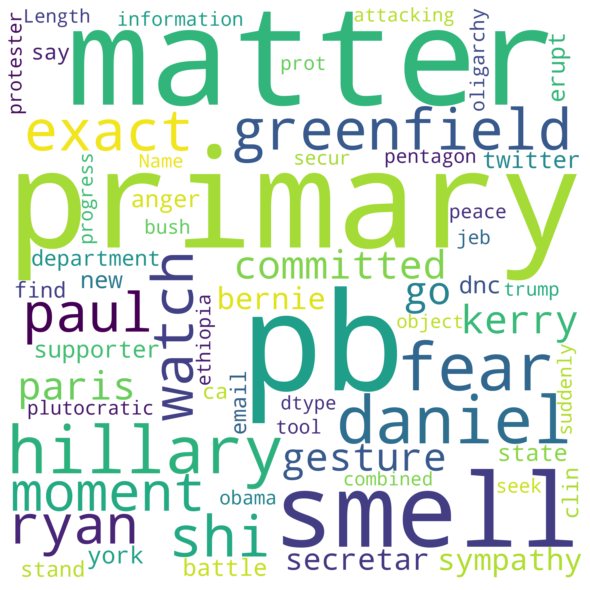

In [26]:
#word cloud representing the most frequently used words
wordcloud = WordCloud(
    width = 2000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(news_df['combined']))
fig = plt.figure(
    figsize = (8, 8),
    facecolor = None,
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [27]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()

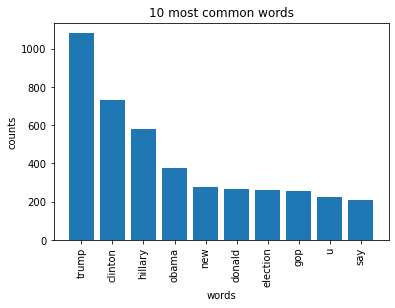

In [28]:
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [18]:
news_df.head()

,title,text,label,title_sent,text_sent,prediction_label,title_orig,text_orig
0,"[smell, hillary, fear]","[daniel, greenfield, shillman, journalism, fel...",FAKE,-0.4939,-0.9988,1,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello..."
1,"[watch, exact, moment, paul, ryan, committed, ...","[google, pinterest, digg, linkedin, reddit, st...",FAKE,-0.5267,0.7723,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,"[kerry, go, paris, gesture, sympathy]","[secretary, state, john, kerry, said, monday, ...",REAL,0.3612,0.9595,0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...
3,"[bernie, supporter, twitter, erupt, anger, dnc...","[kaydee, king, kaydeeking, november, lesson, t...",FAKE,-0.3595,-0.4242,1,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,"[battle, new, york, primary, matter]","[primary, day, new, york, hillary, clinton, do...",REAL,-0.3612,0.9826,0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...


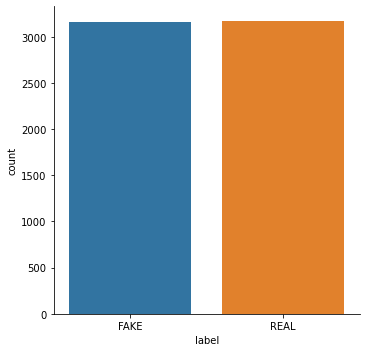

In [24]:
#bar chart representing the fake/ Real news in this dataset
sns.catplot(x='label', kind='count', data=news_df)

[Text(0.5, 0, ''), Text(0.5, 1.0, 'REAL')]

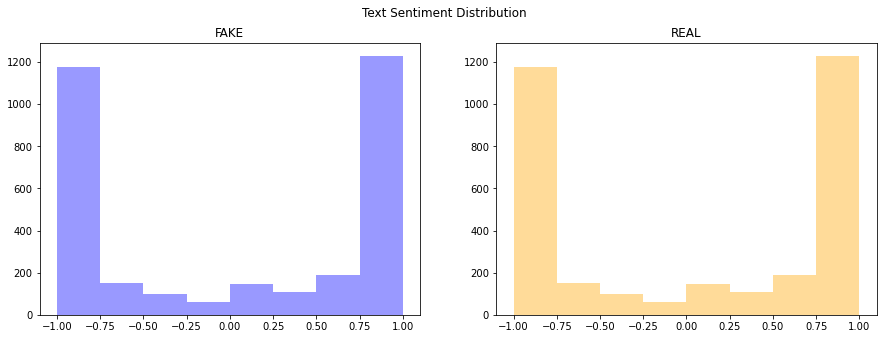

In [79]:
f, axes=plt.subplots(1, 2, figsize=(15, 5) )
f.suptitle("Text Sentiment Distribution")

sns.distplot(news_df[news_df.label=='FAKE']['text_sent'], ax=axes[0], kde=False, color='blue')
axes[0].set(xlabel=None, title='FAKE')
sns.distplot(news_df[news_df.label=='FAKE']['text_sent'], ax=axes[1], kde=False, color='orange')
axes[1].set(xlabel=None, title='REAL')


## Part 3: Modelling

In [93]:
# check for class imbalance 
categories.value_counts() 

# dataset is fairly balanced in the two classes

0    3171
1    3164
Name: prediction_label, dtype: int64

In [94]:
#tfidf training and test datasets: 

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidf_features, categories, test_size=0.3, random_state=42)

In [95]:
#w2v embedding training and test datasets:

X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(w2v_vectors, categories, test_size=0.3, random_state=42)

In [117]:
k_fold=5

In [97]:
# flatten out vector array into pandas columns for input into NB classifier
data=[]
for i in w2v_vectors:
    i.reshape(1, 300)
    data.append(i.tolist())

In [98]:
flattened_em=pd.DataFrame(data)
flattened_em["title_sent"] = news_df['title_sent']
flattened_em["text_sent"] = news_df['text_sent']
flattened_em.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,title_sent,text_sent
0,0.057327,0.045599,0.025604,0.061268,-0.085276,-0.022541,0.028998,-0.053078,0.084359,0.054557,...,-0.060427,0.021519,-0.062594,-0.063116,0.005847,-0.079187,-0.018615,0.036467,-0.4939,-0.9988
1,0.027843,0.047463,0.021543,0.101250,-0.062751,-0.044283,0.032048,-0.076805,0.123853,0.060120,...,-0.082698,0.019953,-0.069039,-0.096247,0.011889,-0.069994,-0.018462,0.034930,-0.5267,0.7723
2,-0.028074,0.039853,0.050990,0.078486,-0.046615,-0.045704,0.018534,-0.139602,0.076804,0.036503,...,-0.050653,0.012012,-0.037772,-0.029351,-0.036106,-0.065438,0.027356,0.004403,0.3612,0.9595
3,0.039635,0.014241,0.014139,0.092180,-0.081838,-0.027465,0.013423,-0.056641,0.101483,0.031725,...,-0.052874,-0.051375,-0.033873,-0.095825,-0.011113,-0.070474,-0.030532,0.053498,-0.3595,-0.4242
4,0.024257,0.053159,0.018278,0.002307,-0.026176,-0.065155,-0.037584,-0.076285,0.050568,0.087655,...,-0.060593,-0.049937,-0.019989,-0.063685,-0.009511,-0.047892,-0.019586,-0.001257,-0.3612,0.9826


In [99]:
# use indices of X_train_em to subset to train/test datasets for the flattened dataset in order to fit a NB model
X_train_em_flat=flattened_em.iloc[X_train_em.index, :]
X_test_em_flat=flattened_em.iloc[X_test_em.index, :]

In [100]:
# check that the subsetting worked correctly
(X_train_em_flat.index==y_train_em.index).all()

True

In [101]:
(X_test_em_flat.index==y_test_em.index).all()

True

#### Naive Bayes

#### TFIDF

In [90]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

In [91]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [96]:
#Training

NB = GaussianNB() 
NB.fit(X_train_tf, y_train_tf)
y_pred = NB.predict(X_test_tf)

In [35]:
cv_scores=cross_val_score(NB, X_train_tf, y_train_tf, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Logistic Regression:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Logistic Regression:
 [0.82863585 0.82412627 0.83652762 0.81285231 0.83521445]
mean cross validation score:
0.8275


In [36]:
#Testing
conf_matrix = confusion_matrix(y_test_tf, y_pred)
print('confusion matrix:')
print(conf_matrix)
print('test accuracy score:\n', accuracy_score(y_test_tf, y_pred))

confusion matrix:
[[831 102]
 [236 732]]
test accuracy score:
 0.8221988427143608


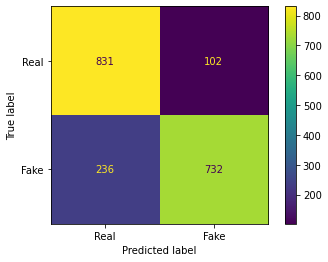

In [37]:
plot_confusion_matrix(NB, X_test_tf, y_test_tf, labels=[0, 1], display_labels=['Real', 'Fake'])

##### W2V

In [102]:
NB_em = GaussianNB() 
NB_em.fit(X_train_em_flat, y_train_em)
y_pred_NB_em = NB_em.predict(X_test_em_flat)

In [43]:
cv_scores=cross_val_score(NB, X_train_em_flat, y_train_em, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Naive Bayes Classifier:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Naive Bayes Classifier:
 [0.63585118 0.66290868 0.70687711 0.68883878 0.66139955]
mean cross validation score:
0.6712


In [44]:
#Testing
conf_matrix = confusion_matrix(y_test_em, y_pred_NB_em)
print('confusion matrix:')
print(conf_matrix)
print('test accuracy score:\n', accuracy_score(y_test_em, y_pred_NB_em))

confusion matrix:
[[748 185]
 [433 535]]
test accuracy score:
 0.6749079431877959


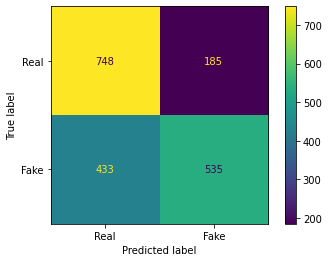

In [45]:
plot_confusion_matrix(NB_em, X_test_em_flat, y_test_em, labels=[0, 1], display_labels=['Real', 'Fake'])

#### Logistic Regression

##### TF-IDF

In [103]:
# Training
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_tf, y_train_tf)

LogisticRegression()

In [46]:
cv_scores=cross_val_score(logreg, X_train_tf, y_train_tf, cv=k_fold, n_jobs=2)
print('5-fold cross validation score of Logistic Regression:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Logistic Regression:
 [0.8951522  0.89853439 0.89740699 0.88726043 0.89841986]
mean cross validation score:
0.8954


In [47]:
# Testing

y_pred = logreg.predict(X_test_tf)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test_tf, y_test_tf)))
conf_matrix = confusion_matrix(y_test_tf, y_pred)
print(conf_matrix)
print('test accuracy score:\n{:.4f}'.format(accuracy_score(y_test_tf, y_pred)))

Accuracy of logistic regression classifier on test set: 0.9095
[[857  76]
 [ 96 872]]
test accuracy score:
0.9095


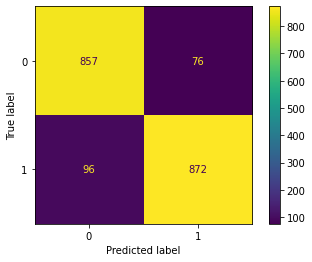

In [48]:
plot_confusion_matrix(logreg, X_test_tf, y_test_tf)

##### Word2Vec

In [104]:
logreg_em = LogisticRegression()
logreg_em.fit(X_train_em_flat, y_train_em)

LogisticRegression()

In [49]:
cv_scores=cross_val_score(logreg, X_train_em_flat, y_train_em, cv=k_fold, n_jobs=2)
print('5-fold cross validation score of Logistic Regression:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Logistic Regression:
 [0.82412627 0.85231116 0.83878241 0.85682074 0.83182844]
mean cross validation score:
0.8408


In [50]:
y_pred_logreg_em = logreg_em.predict(X_test_em_flat)
conf_matrix = confusion_matrix(y_test_em, y_pred_logreg_em)
print(conf_matrix)
print('test accuracy of logistic regression (W2V): {:.4f}'.format(accuracy_score(y_test_tf, y_pred_logreg_em)))

[[795 138]
 [148 820]]
test accuracy of logistic regression (W2V): 0.8496


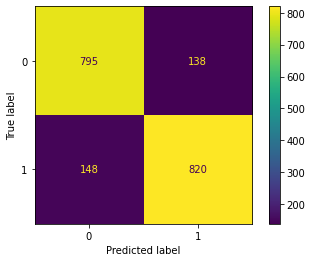

In [51]:
plot_confusion_matrix(logreg_em, X_test_em_flat, y_test_em)

#### XGBoost

##### TF-IDF

In [105]:
import xgboost as xgb
xgb_tf = xgb.XGBClassifier()
xgb_tf.fit(X_train_tf, y_train_tf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
cv_scores=cross_val_score(xgb_tf, X_train_tf, y_train_tf, cv=k_fold, n_jobs=2)
print('5-fold cross validation score of XGBoost (TFIDF):\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of XGBoost (TFIDF):
 [0.98985344 0.98985344 0.99210823 0.98647125 0.99097065]
mean cross validation score:
0.9899


In [53]:
y_pred_xgb = xgb_tf.predict(X_test_tf)
conf_matrix = confusion_matrix(y_test_tf.to_numpy(), y_pred_xgb)
print(conf_matrix)
print('test accuracy of xgboost classifier (TFIDF): {:.4f}'.format(accuracy_score(y_test_tf.to_numpy(), y_pred_xgb)))

[[923  10]
 [  2 966]]
test accuracy of xgboost classifier (TFIDF): 0.9937


Text(0.5, 1.0, 'XGBoost Confusion Matrix (TFIDF)')

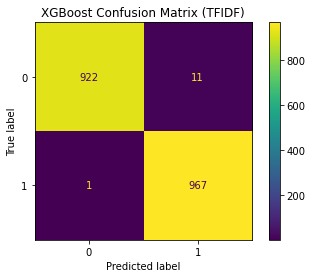

In [138]:
plot_confusion_matrix(xgb_tf, X_test_tf, y_test_tf)
plt.title('XGBoost Confusion Matrix (TFIDF)')

##### Word2Vec

In [106]:
xgb_em = xgb.XGBClassifier()
xgb_em.fit(X_train_em_flat, y_train_em)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
cv_scores=cross_val_score(xgb_em, X_train_em_flat, y_train_em, cv=k_fold, n_jobs=2)
print('5-fold cross validation score of XGBoost (TFIDF):\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of XGBoost (TFIDF):
 [0.86696731 0.87260428 0.87373168 0.89064262 0.87133183]
mean cross validation score:
0.8751


In [56]:
y_pred_xgb = xgb_em.predict(X_test_em_flat)
conf_matrix = confusion_matrix(y_test_em.to_numpy(), y_pred_xgb)
print(conf_matrix)
print('test accuracy of xgboost classifier (TFIDF): {:.4f}'.format(accuracy_score(y_test_em.to_numpy(), y_pred_xgb)))

[[811 122]
 [116 852]]
test accuracy of xgboost classifier (TFIDF): 0.8748


Text(0.5, 1.0, 'XGBoost Confusion Matrix (w2v)')

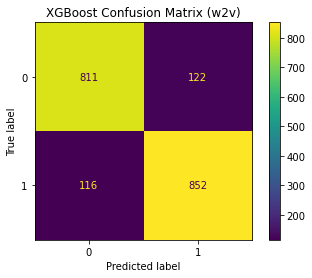

In [139]:
plot_confusion_matrix(xgb_em, X_test_em_flat, y_test_em)
plt.title('XGBoost Confusion Matrix (w2v)')

#### Decision trees

##### TF-IDF

In [107]:
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(max_depth=10)
decisionTree.fit(X_train_tf, y_train_tf)

DecisionTreeClassifier(max_depth=10)

In [58]:
cv_scores=cross_val_score(decisionTree, X_train_tf, y_train_tf, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Decision Tree classifier:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Decision Tree classifier:
 [0.97632469 0.98083427 0.98647125 0.97519729 0.97968397]
mean cross validation score:
0.9797


In [59]:
dt_preds = decisionTree.predict(X_test_tf)
conf_matrix = confusion_matrix(y_test_tf, dt_preds)
print(conf_matrix)
print('test accuracy of DecisionTree classifier on test set: {:.4f}'.format(accuracy_score(dt_preds, y_test_tf)))

[[915  18]
 [ 16 952]]
test accuracy of DecisionTree classifier on test set: 0.9821


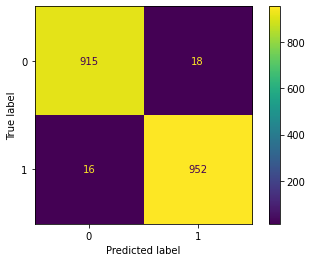

In [60]:
plot_confusion_matrix(decisionTree, X_test_tf, y_test_tf)

##### Word2Vec

In [108]:
decisionTree_em = DecisionTreeClassifier(max_depth=10)
decisionTree_em.fit(X_train_em_flat, y_train_em)

DecisionTreeClassifier(max_depth=10)

In [61]:
cv_scores=cross_val_score(decisionTree_em, X_train_em_flat, y_train_em, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Decision Tree classifier:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Decision Tree classifier:
 [0.75422773 0.7373168  0.74408117 0.75760992 0.72460497]
mean cross validation score:
0.7436


In [62]:
dt_preds = decisionTree_em.predict(X_test_em_flat)
conf_matrix = confusion_matrix(y_test_em, dt_preds)
print(conf_matrix)
print('test accuracy of DecisionTree classifier on test set: {:.4f}'.format(accuracy_score(dt_preds, y_test_em)))

[[704 229]
 [249 719]]
test accuracy of DecisionTree classifier on test set: 0.7486


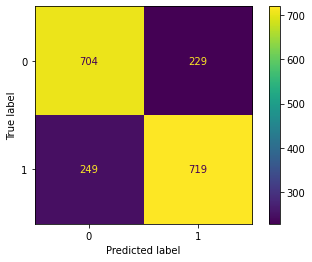

In [63]:
plot_confusion_matrix(decisionTree_em, X_test_em_flat, y_test_em)

#### MLPClassifier

##### TF-IDF

In [109]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='sgd', learning_rate='constant', max_iter=30)
mlp.fit(X_train_tf, y_train_tf)

MLPClassifier(max_iter=30, solver='sgd')

In [64]:
cv_scores=cross_val_score(mlp, X_train_tf, y_train_tf, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Decision Tree classifier:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximu

5-fold cross validation score of Decision Tree classifier:
 [0.53100338 0.58399098 0.56595265 0.59977452 0.55530474]
mean cross validation score:
0.5672


/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [65]:
mlp_preds = mlp.predict(X_test_tf)
conf_matrix = confusion_matrix(y_test_tf, mlp_preds)
print(conf_matrix)
print('test of MLP classifier: {:.4f}'.format(accuracy_score(mlp_preds, y_test_tf)))

[[590 343]
 [474 494]]
test of MLP classifier: 0.5702


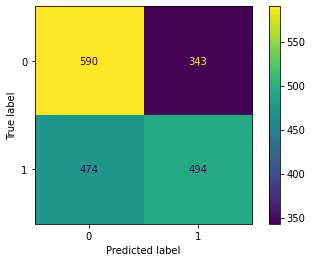

In [66]:
plot_confusion_matrix(mlp, X_test_tf, y_test_tf)

##### Word2Vec

In [110]:
mlp_em = MLPClassifier(solver='sgd', learning_rate='constant', max_iter=30)
mlp_em.fit(X_train_em_flat, y_train_em)

MLPClassifier(max_iter=30, solver='sgd')

In [67]:
cv_scores=cross_val_score(mlp_em, X_train_em_flat, y_train_em, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Decision Tree classifier:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximu

5-fold cross validation score of Decision Tree classifier:
 [0.52423901 0.5794814  0.55693348 0.59301015 0.54401806]
mean cross validation score:
0.5595


/home/matto/git/ai-final-project/.venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [68]:
mlp_preds = mlp_em.predict(X_test_em_flat)
conf_matrix = confusion_matrix(y_test_em, mlp_preds)
print(conf_matrix)
print('test of MLP classifier: {:.4f}'.format(accuracy_score(mlp_preds, y_test_em)))

[[577 356]
 [461 507]]
test of MLP classifier: 0.5702


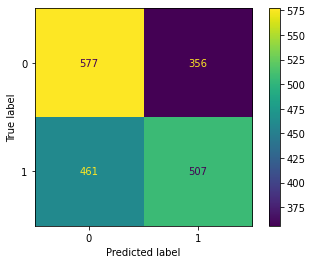

In [69]:
plot_confusion_matrix(mlp_em, X_test_em_flat, y_test_em)

#### Random Forest

##### TF-IDF

In [111]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train_tf,y_train_tf)

RandomForestClassifier()

In [70]:
cv_scores=cross_val_score(rf, X_train_tf, y_train_tf, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Decision Tree classifier:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Decision Tree classifier:
 [0.97181511 0.9740699  0.98647125 0.98534386 0.97291196]
mean cross validation score:
0.9781


In [71]:
rf_pred=rf.predict(X_test_tf)
conf_matrix = confusion_matrix(y_test_tf, rf_pred)
print(conf_matrix)
print('Accuracy of RandomForest classifier on test set: {:.4f}'.format(accuracy_score(rf_pred, y_test_tf)))

[[906  27]
 [  8 960]]
Accuracy of RandomForest classifier on test set: 0.9816


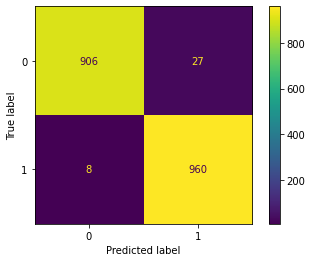

In [72]:
plot_confusion_matrix(rf, X_test_tf, y_test_tf)

##### Word2Vec

In [112]:
rf_em = RandomForestClassifier(n_estimators=100)
rf_em.fit(X_train_em_flat,y_train_em)

RandomForestClassifier()

In [73]:
cv_scores = cross_val_score(rf_em, X_train_em_flat, y_train_em, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Decision Tree classifier:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Decision Tree classifier:
 [0.82750846 0.85005637 0.85118377 0.85794814 0.83521445]
mean cross validation score:
0.8444


In [74]:
rf_pred = rf_em.predict(X_test_em_flat)
conf_matrix = confusion_matrix(y_test_em, rf_pred)
print(conf_matrix)
print('Accuracy of RandomForest classifier on test set: {:.4f}'.format(accuracy_score(rf_pred, y_test_em)))

[[788 145]
 [119 849]]
Accuracy of RandomForest classifier on test set: 0.8611


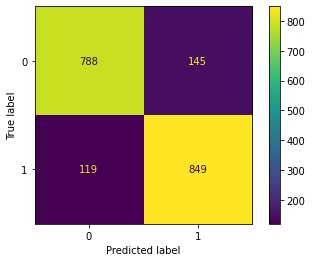

In [75]:
plot_confusion_matrix(rf_em, X_test_em_flat, y_test_em)

#### SUPPORT VECTOR MACHINE (SVM)

#### TFIDF

In [121]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
sv = svm.SVC(kernel='linear', probability=True) 

#Train the model using the training sets
sv.fit(X_train_tf, y_train_tf)

SVC(kernel='linear', probability=True)

In [122]:
cv_scores=cross_val_score(sv, X_train_tf, y_train_tf, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Support Vector Machine:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Support Vector Machine:
 [0.94588501 0.94926719 0.95603157 0.93348365 0.94018059]
mean cross validation score:
0.9450


In [123]:
#Predict the response for test dataset
sv_pred = sv.predict(X_test_tf)
print('Accuracy of Support Vector Machine on test set (TFIDF): {:.4f}'.format(accuracy_score(sv_pred, y_test_tf)))

Accuracy of Support Vector Machine on test set (TFIDF): 0.9579


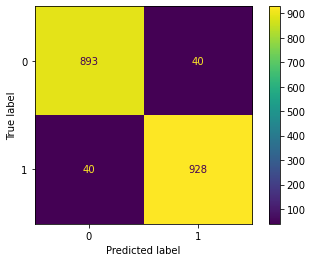

In [133]:
plot_confusion_matrix(sv, X_test_tf, y_test_tf)

#### Word2Vec

In [130]:
#Create a svm Classifier
sv_em = svm.SVC(kernel='linear', probability=True) 

#Train the model using the training sets
sv_em.fit(X_train_em_flat,y_train_em)

SVC(kernel='linear', probability=True)

In [131]:
cv_scores=cross_val_score(sv,X_train_em_flat, y_train_em, cv=k_fold, n_jobs=1)
print('5-fold cross validation score of Support Vector Machine:\n', cv_scores)
print('mean cross validation score:\n{:.4f}'.format(np.array(cv_scores).mean()))

5-fold cross validation score of Support Vector Machine:
 [0.86133033 0.85907554 0.85794814 0.85907554 0.8476298 ]
mean cross validation score:
0.8570


In [132]:
#Predict the response for test dataset
sv_pred = sv_em.predict(X_test_em_flat)
print('Accuracy of Support Vector Machine on test set (w2v): {:.4f}'.format(accuracy_score(sv_pred,y_test_em)))

Accuracy of Support Vector Machine on test set (w2v): 0.8617


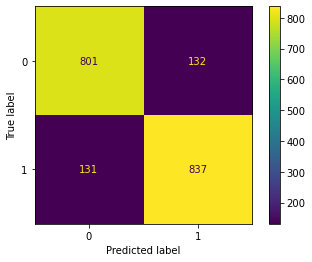

In [134]:
plot_confusion_matrix(sv_em, X_test_em_flat, y_test_em)

## Part 4: Model Comparison and Evaluation

In [126]:
# TFIDF classifiers
models = [NB,
          logreg,
          decisionTree,
          rf,
          xgb_tf,
          mlp,
         sv]

result_table = pd.DataFrame(columns=['classifier', 'fpr','tpr','auc'])

for model in models:
    #model = cls.fit(X_train_tf, y_train_tf)
    yproba = model.predict_proba(X_test_tf)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test_tf,  yproba)
    auc = roc_auc_score(y_test_tf, yproba)
    
    result_table = result_table.append({'classifier':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
#result_table.set_index('classifier', inplace=True)

In [127]:
result_table.set_index('classifier', inplace=True)

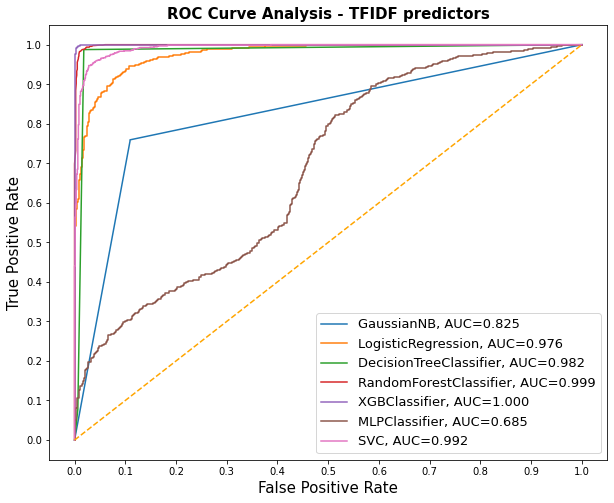

In [128]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis - TFIDF predictors', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [135]:
# Word2Vec Classifiers
models = [NB_em,
          logreg_em,
          decisionTree_em,
          rf_em,
          xgb_em,
          mlp_em,
         sv_em]

result_table = pd.DataFrame(columns=['classifier', 'fpr','tpr','auc'])

for model in models:
    #model = cls.fit(X_train_tf, y_train_tf)
    yproba = model.predict_proba(X_test_em_flat)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test_tf,  yproba)
    auc = roc_auc_score(y_test_tf, yproba)
    
    result_table = result_table.append({'classifier':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
#result_table.set_index('classifier', inplace=True)

In [136]:
result_table.set_index('classifier', inplace=True)

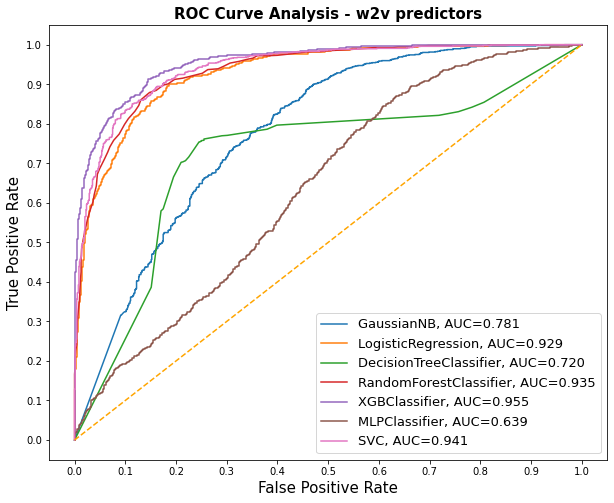

In [137]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis - w2v predictors', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### LSTM model with google news pretrained word2vec model

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [22]:
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 300

In [23]:
x_train,x_test,y_train,y_test = train_test_split(news_df.combined,news_df.prediction_label,random_state = 42, test_size=0.3, shuffle=True)

In [24]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4434,)
(4434,)
(1901,)
(1901,)


In [25]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)

# Transforms each text in texts to a sequence of integers. 
tokenized_train = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(tokenized_train, maxlen=MAX_SEQUENCE_LENGTH)
word_index = tokenizer.word_index
print('Found {} unique tokens. and {} lines '.format(len(word_index), len(X_train)))

Found 47625 unique tokens. and 4434 lines 


In [26]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=MAX_SEQUENCE_LENGTH)

In [27]:
def get_embeddings(path):
  #extracting word vectors from google news vector
    embeddings_index = {}
    for word, vector in zip(w2v_model.vocab, w2v_model.vectors):
        coefs = np.asarray(vector, dtype='float32')
        embeddings_index[word] = coefs
  
    return embeddings_index

In [28]:
embeddings_index = {}
embeddings_index = get_embeddings('GoogleNews-vectors-negative300.bin')
print('Found %s word vectors.' % len(embeddings_index))

Found 3000000 word vectors.


In [29]:
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

In [30]:
del embeddings_index # for saving memory

In [31]:
def lstm_net1():
    model = Sequential()

    #Non-trainable embeddidng layer since we are using a pretrained word2vec model
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(LSTM(units=128 , return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.1))
    model.add(Dense(units = 32 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [32]:
#training an LSTM network
model = lstm_net1()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          14287800  
_________________________________________________________________
lstm (LSTM)                  (None, 500, 128)          219648    
_________________________________________________________________
dropout (Dropout)            (None, 500, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [33]:
es = EarlyStopping(monitor='val_accuracy', patience = 3)

In [34]:
history = model.fit(X_train, y_train, batch_size = 256 , validation_data = (X_test,y_test) , epochs = 8, callbacks=[es])

Epoch 1/8
18/18 [==============================] - 92s 5s/step - loss: 0.6049 - accuracy: 0.6874 - val_loss: 0.5250 - val_accuracy: 0.7538
Epoch 2/8
18/18 [==============================] - 119s 7s/step - loss: 0.4452 - accuracy: 0.8033 - val_loss: 0.4293 - val_accuracy: 0.8327
Epoch 3/8
18/18 [==============================] - 133s 7s/step - loss: 0.3793 - accuracy: 0.8392 - val_loss: 0.4765 - val_accuracy: 0.8448
Epoch 4/8
18/18 [==============================] - 138s 8s/step - loss: 0.4141 - accuracy: 0.8363 - val_loss: 0.4023 - val_accuracy: 0.8464
Epoch 5/8
18/18 [==============================] - 146s 8s/step - loss: 0.5043 - accuracy: 0.7700 - val_loss: 0.4548 - val_accuracy: 0.7864
Epoch 6/8
18/18 [==============================] - 150s 8s/step - loss: 0.4309 - accuracy: 0.8054 - val_loss: 0.4127 - val_accuracy: 0.8143
Epoch 7/8
18/18 [==============================] - 154s 9s/step - loss: 0.3632 - accuracy: 0.8482 - val_loss: 0.3312 - val_accuracy: 0.8595
Epoch 8/8
18/18 [====

In [36]:
lstm_pred = model.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,lstm_pred)
print('test accuracy score:\n', accuracy_score(y_test, lstm_pred))

test accuracy score:
 0.8574434508153603


In [37]:
print(cf_matrix)

[[825 108]
 [163 805]]
